# D213: Time Series Modeling 

## Table of Contents
* [Part 1 - Research Question](#Part1_Research_Question)
    * [A1: Research Question](#A1)
    * [A2: Objectives and Goals of the Analysis](#A2)
* [Part 2 - Method Justification](#Part2)
    * [B1: Assumptions of ARIMA Model](#B1)
* [Part 3 - Data Preparation](#Part3)
    * [C1: Line Graph Representation](#C1) 
    * [C2: Time Step Formatting](#C2)
    * [C3: Stationarity of Time Series](#C3)
    * [C4: Steps for Preparing Data](#C4)
    * [C5: CSV File for Prepared Data](#C5) 
* [Part 4 - Model Identification and Analysis](#Part4)
    * [D1: Data Visualizations](#D1)
        * [Seasonal Component](#Seasonality)
        * [Trends](#Trends)
        * [Autocorrelation](#Autocorrelation)
        * [Spectral Density](#Density)
        * [Decomposed Time Series](#DTS)
        * [Confirmation of Lack of Trends in Residuals](#Confirmation)
    * [D2: ARIMA Model](#D2)
    * [D3: ARIMA Model Forecast](#D3)
    * [D4: Output and Calculations](#D4)
    * [D5: Code Used for Model](#D5)
 * [Part 5 - Data Summary and Implications](#Part5)
     * [E1: Results](#E1)
         * [Selection of the ARIMA Model](#Selection)
         * [Prediction Interval of the Forecast](#Prediction)
         * [Justification of the Forecast Length](#Length)
         * [Model of Evaluation Procedure and Error Metric](#Evaluation)
     * [E2: Annotated Visualization](#E2)
     * [E3: Recommended Course of Action](#E3)
 * [Part 6 - Reporting](#Part6)

## Part 1 - Research Question <a class="anchor" id="Part1_Research_Question"></a>

### A1: Research Question <a class="anchor" id="A1"></a>

The research question that I would like to address for this project is:

Can I accurately forecast the revenue data for the telecommunications company using ARIMA compared to the observed and recorded data that the company already has? In other words, can I create a time series model that accurately forecasts data? This will be tested against the data the company already has to determine if the forecast is accurate.

### A2: Objectives and Goals of the Analysis <a class="anchor" id="A2"></a>

The goal of this analysis is to be able to accurately forcast the next quarter (3 months) of revenue for the telecommunications company based on the data that has been provided. The dataset provided contains the last two years worth of the company's revenue, so I will use this to create a training set that will train my ARIMA model and a test set that the training data will be tested against. By the end of the analysis the goal is to have an understanding of the company's current revenue as well as accurate revenue projections for the next three months.

## Part 2 - Method Justification <a class="anchor" id="Part2"></a>

### B1: Assumptions of ARIMA Model <a class="anchor" id="B1"></a>

Some assumptions of the ARIMA model are:
    
 - Stationarity - This means that the model assumes that the time series is stationary without trend or seasonality.       Stationarity implies that the variance and mean are constant over the period of time. Stationarity also implies that the autocorrelation of the time series data stays constant.

 - Autocorrelation - This assumption refers to the correlation of time series data and with its past values. The relationship is important for the model to produce accurate results and to set the order for the model. This correlation can be further understood using an autocorrelation plot of the data. 

## Part 3 - Data Preparation <a class="anchor" id="Part3"></a>

In [1]:
#Import all libraries needed for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, date, timedelta

In [2]:
#Read in the csv file containing the data
df = pd.read_csv("C:/Users/sered/OneDrive/Desktop/WGU Masters Degree/D213/teleco_time_series .csv")
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [3]:
#Understand shape and datatypes in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [4]:
df.shape

(731, 2)

<b> Convert the Day Column to a DateTime Datatype </b>

In order to accurately complete the analysis, the 'Day' column data must be converted from an int to a DateTime datatype. This is necessary so that the model has a time series to work with. As of now the dataset just contains two numbers. Converting the 'Day' column to a datatime datatype is done by using the pandas library to set the date using the to_datetime() method and then is completed by taking the timedelta from the DateTime library to get the accurate start date. This new date is then inserted into the 'Day' column and will be used moving forward.

In [5]:
#Format the Day column into a complete date yyyy-mm-dd for easier use in analysis
start_date = pd.to_datetime('2022-01-01')
res_date = pd.to_timedelta(df['Day'] - 1, unit='D') + start_date
df['Day'] = res_date
df.head()

,Day,Revenue
0,2022-01-01,0.000000
1,2022-01-02,0.000793
2,2022-01-03,0.825542
3,2022-01-04,0.320332
4,2022-01-05,1.082554


In [6]:
#Set datetime column as index
df.set_index('Day', inplace=True)
df.head()

,Revenue
Day,
2022-01-01,0.000000
2022-01-02,0.000793
2022-01-03,0.825542
2022-01-04,0.320332
2022-01-05,1.082554


### C1: Line Graph Representation <a class="anchor" id="C1"></a>

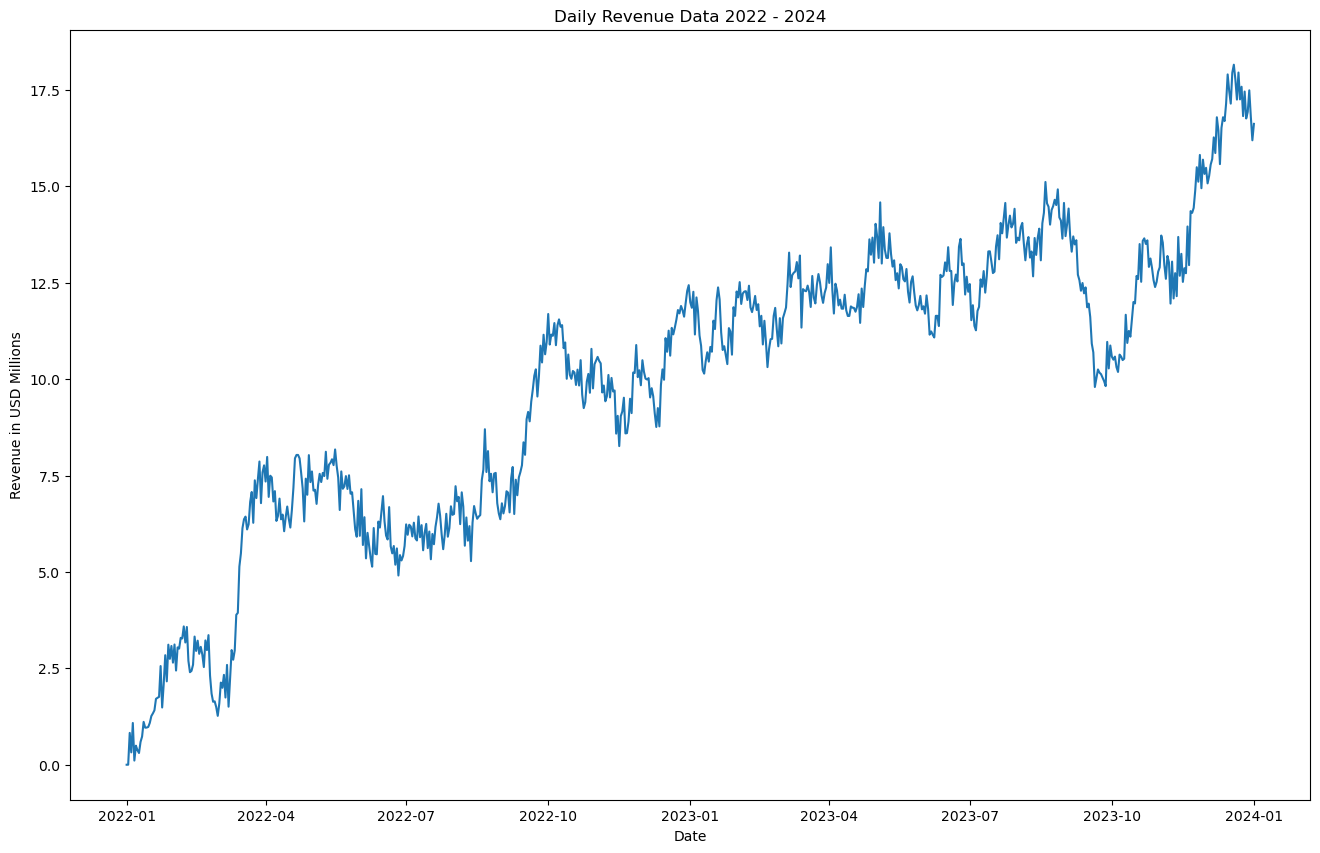

In [7]:
#Create a line graph representing the time series data
plt.figure(figsize = [16,10])
plt.title("Daily Revenue Data 2022 - 2024")
plt.xlabel("Date")
plt.ylabel("Revenue in USD Millions")

plt.plot(df)

### C2: Time Step Formatting <a class="anchor" id="C2"></a>

The time series plotted above represents the daily revenue data from the telecommunications company from January 1, 2022 - January 1, 2024. In total the time series is made up 731 daily data points that were taken from the company over the last two years. It would seem that the extra day is because one of the years was a leap year. Looking at the graph above, there does not appear to be any gaps in the data. 

### C3: Stationarity of Time Series <a class="anchor" id="C3"></a>

In [8]:
#I will use the Augmented Dickey-Fuller test to test stationarity
#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [9]:
#below code found from the following source: (G, 2024). Please see references for more details.
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

adf_test(df['Revenue'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.924612
p-value                          0.320573
#Lags Used                       1.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
dtype: float64
Test Statistic                  -1.924612
p-value                          0.320573
#Lags Used                       1.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
Critical Value (5%)             -2.865513
dtype: float64
Test Statistic                  -1.924612
p-value                          0.320573
#Lags Used                       1.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
Critical Value (5%)             -2.865513
Critical Value (10%)            -2.568886
dtype: float64


Based on the Augmented Dickey-Fuller test that was performed above we can see that the p-value is higher than the significance value of 0.05 and the test statistic (-1.92) is larger than all of the critical values (-3.44, -2.87, -2.57). This indicates that the time series is non-stationary. Looking at the graph above these are the results that we were expecting to see. The graph clearly shows that the revenue is trending upward and a stationary time series does not have a trend. This upward trend in our time series proves that it is non-stationary just like the test confirmed.

### C4: Steps for Preparing Data <a class="anchor" id="C4"></a>

The following are the steps taken to prepare the time series data:
 - Convert the 'Day' column to a DateTime rather than an int (completed above before line graph)
 - Transform the Revenue data into a stationary time series since the test above showed that it is non-stationary
 - Separate the data into training and test sets

<b> Transform the non-Stationary Data to Stationary Using Differencing </b>

Because of the ADF test perfomred above we know that the time series is currently a non-stationary time series. Before we can move forward with more analysis of the data, we must first transform the series into a stationary time series without any trend or seasonality. This is an important data preparation step because non-stationary data can lead to unreliable results and model outputs later in the process. We will convert the non-stationary data into a stationary time series using a method called differencing. This process is performed by subtracting the current value of a series from the previous value. This process is repeated until all of the data (specifically for revenue in our dataset) has been differenced and is no longer non-stationary.

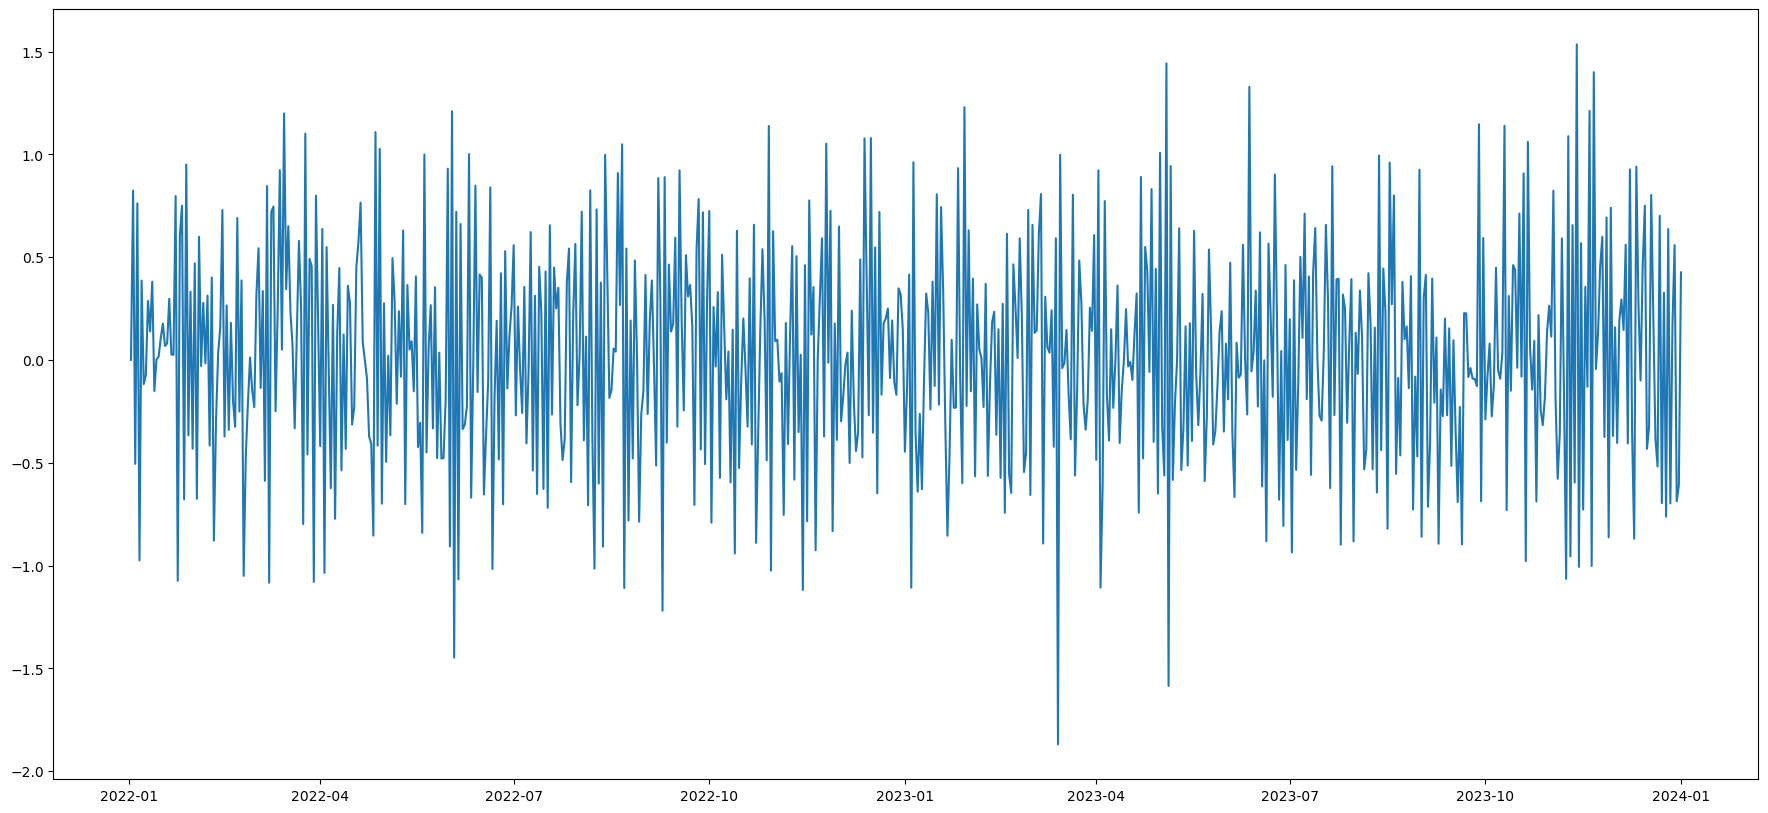

In [10]:
#Use differencing to convert our non-stationary time series to a stationary time series
df['Revenue'] = df['Revenue'] - df['Revenue'].shift(1).dropna()
plt.figure(figsize=(22,10))
plt.plot(df)

After completeing the differencing we can see from the above graph that the seasonality and trends have been removed from the time series. To confirm this we can run another ADF test.

In [11]:
#confirmation of non-stationarity transformation
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

adf_test(df['Revenue'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -44.874527
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
dtype: float64
Test Statistic                 -44.874527
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
Critical Value (5%)             -2.865513
dtype: float64
Test Statistic                 -44.874527
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
Critical Value (5%)             -2.865513
Critical Value (10%)            -2.568886
dtype: float64


The p-value is no longer above the significance threshold and the test statistic is far below the critical values produced by the test. This confirms that the time sereies is now stationary and we can proceed with splitting into training and test sets.

<b> Separate the Data into Training and Test Sets </b>

To get accurate results from the model the data must be split into training and test data. The training data will be used to train the model while the test data is used to test how accurately the model is working. For this model, I will be using 80% of the data to train the model and the other 20% will be used to test the model.

In [12]:
#split the time series into training and testing sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df.dropna(), test_size=0.2, shuffle=False, random_state=42)
train

,Revenue
Day,
2022-01-02,0.000793
2022-01-03,0.824749
2022-01-04,-0.505210
2022-01-05,0.762222
2022-01-06,-0.974900
...,...
2023-08-04,0.113264
2023-08-05,-0.531705
2023-08-06,-0.437835


In [13]:
test

,Revenue
Day,
2023-08-09,-0.531923
2023-08-10,0.157387
2023-08-11,-0.644689
2023-08-12,0.995057
2023-08-13,-0.438775
...,...
2023-12-28,0.170280
2023-12-29,0.559108
2023-12-30,-0.687028


### C5: CSV File for Prepared Data <a class="anchor" id="C5"></a>

In [14]:
#Save training and test data to individual csv files
train.to_csv('C:/Users/sered/OneDrive/Desktop/WGU Masters Degree/D213/Assessment 1/training_data.csv')
test.to_csv('C:/Users/sered/OneDrive/Desktop/WGU Masters Degree/D213/Assessment 1/test_data.csv')

## Part 4 - Model Identification and Analysis <a class="anchor" id="Part4"></a>

### D1: Data Visualizations <a class="anchor" id="D1"></a>

### Seasonality <a class="anchor" id="Seasonality"></a>

In [15]:
#Decompose the transformed data to understand seasonality
#Import the seasonal_decompose from the statsmodels library
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(df.dropna(), period=24)

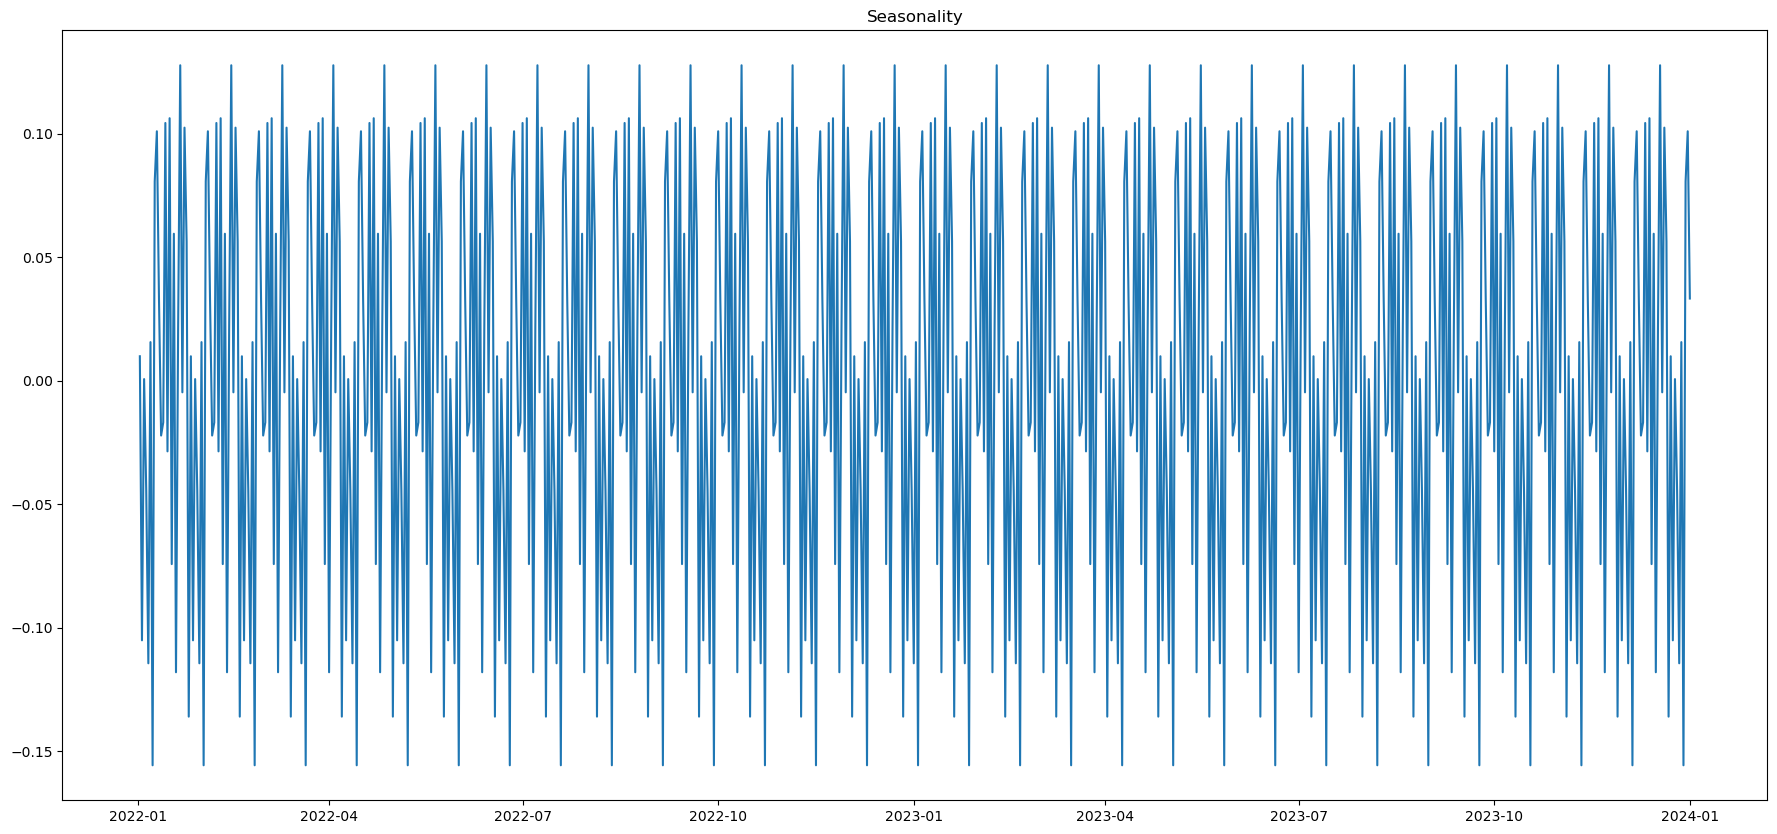

In [16]:
#plot the decomposed dataframe to see seasonality
plt.figure(figsize=(22,10))
plt.title("Seasonality")
plt.plot(sd.seasonal);

In the graph above we can see the seasonality of the time series. In order to understand the seasonality better, we can create a visualization that helps to see the seasonlity more clearly.

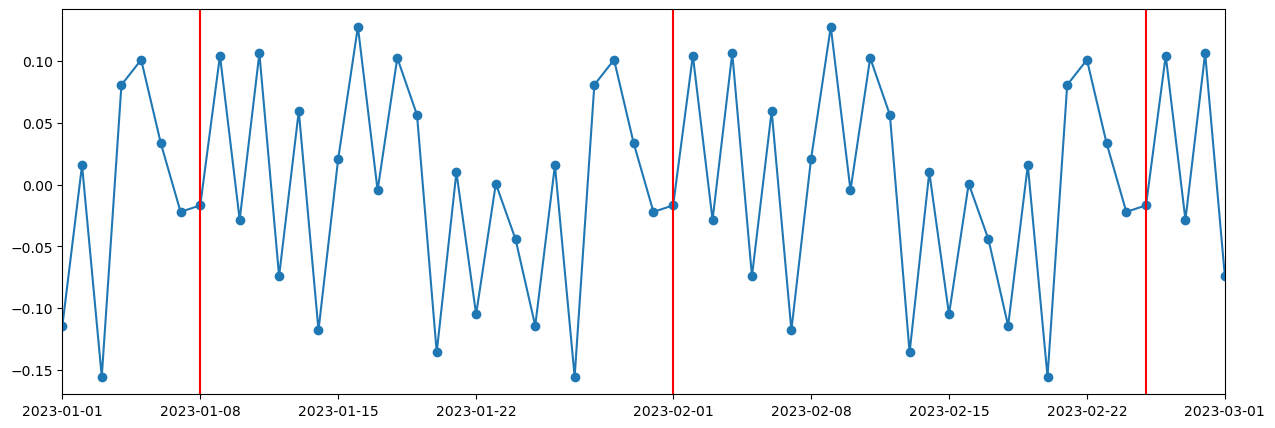

In [17]:
plt.figure(figsize = (15,5))
plt.plot(sd.seasonal, marker='o')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-03-01'))

#place a marker to more clearly define seasonality
plt.axvline(x=pd.to_datetime('2023-01-08'), color='red')
plt.axvline(x=pd.to_datetime('2023-02-01'), color='red')
plt.axvline(x=pd.to_datetime('2023-02-25'), color='red');

Doing this, we can clearly see that the seasonlity reoccurs every 24 days in our time series. These regular and predictable changes in the data are important to understand so that you can determine how to best create the model.

### Trends <a class="anchor" id="Trends"></a>

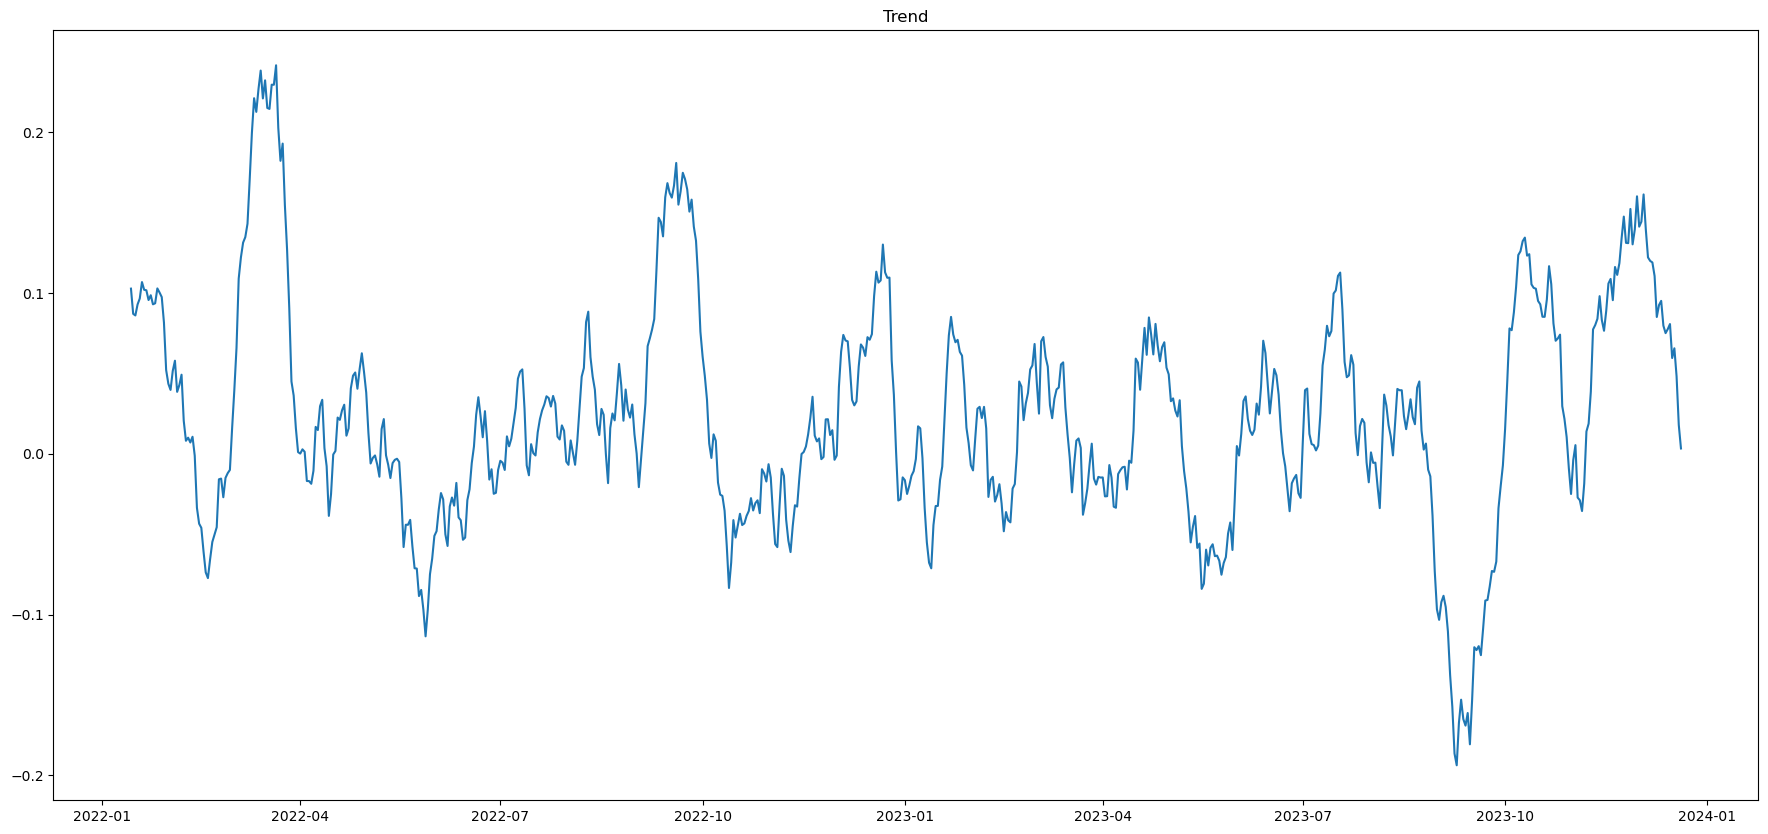

In [18]:
#create a visualization to show the trend of the decomposed data
plt.figure(figsize=(22,10))
plt.title("Trend")
plt.plot(sd.trend);

Based on the graph above, there doesn't appear to be any trends in the time series data. It looks like the data is staying consistent with small positive and negative off shoots every so often, but no trend can be seen.

### Autocorrelation <a class="anchor" id="Autocorrelation"></a>

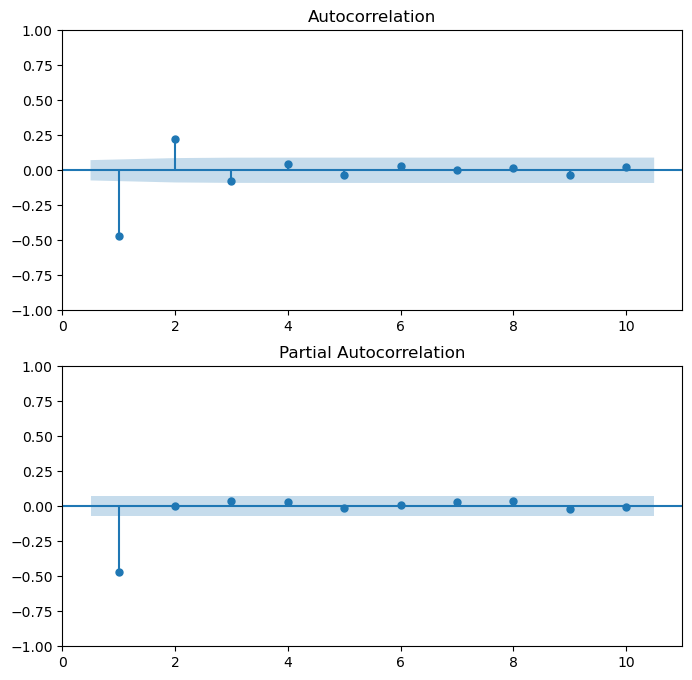

In [19]:
#imoprt necessary libraries from statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Create figure 
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

#Make ACF Plot
plot_acf(df.dropna(), lags=10, zero=False, ax=ax1)

#Make PACF plot
plot_pacf(df.dropna(), lags=10, zero=False, ax=ax2)

plt.show()

The autocorrelation and partial autocorrelation are used to determine the relationships between observations at different points. From the graphs above we can see that much of the data from our time series model is statistically significant and can also see that there is a correlation between data points in our time series.

The autocorrelation is used to "identify which lags have significant correlations, understand the patterns and properties of the time series, and then use that information to model the time series data." (Frost, n.d.) From the autocorrelation plot we can see the representation of correlation in the data and determine which data is statistically significant.

Partial autocorrelation is useful after an analyst has used ACF to determine which autoregressive model is right to use. PACF is then used to determine the specifications and terms of the model.

We will use auto_arima below to determine the best order for the model that support the autocorrelation and partial autocorrelation plots above.

### Spectral Density <a class="anchor" id="Density"></a>

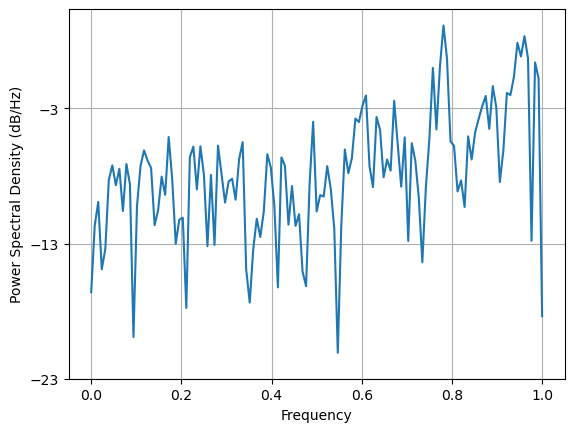

In [20]:
#Create a plot to show spectral density of the time series
plt.psd(df.dropna().Revenue);

The above graph is the power spectral density of the decomposed time series. From this graph we can determine if there are other recurring intervals in the time series. From the graph above we can see that the time series doesn't appear to have any recurring intervals based on frequency and power spectral density.

### Decomposed Time Series <a class="anchor" id="DTS"></a>

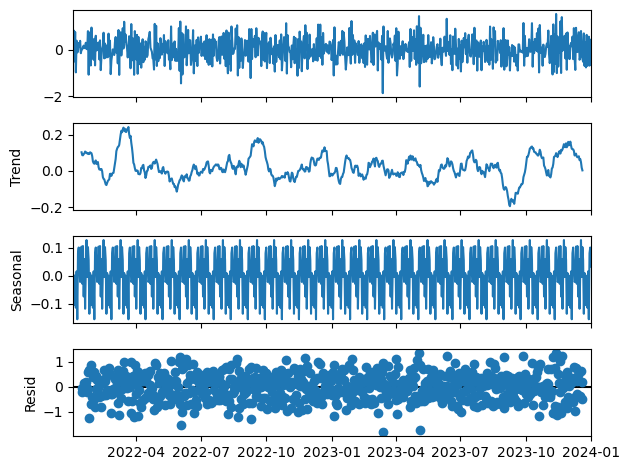

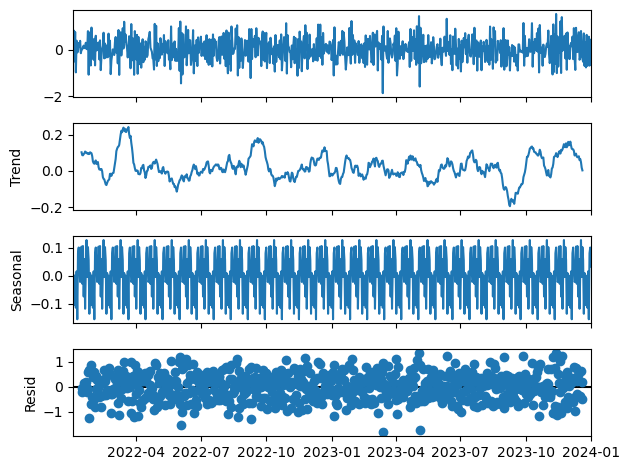

In [21]:
#plot all visualizations from the decomposed time series that was created above
sd.plot()

The above image is a summary of many of the graphs that we have already discussed up to this point. These are graphs of the transformed time series which are very helpful to see and understand. This information can help an analyst to determine how to move forward with the creation of the time series model and ensure optimized functionality.

### Confirmation of Lack of Trends in Residuals <a class="anchor" id="Confirmation"></a>

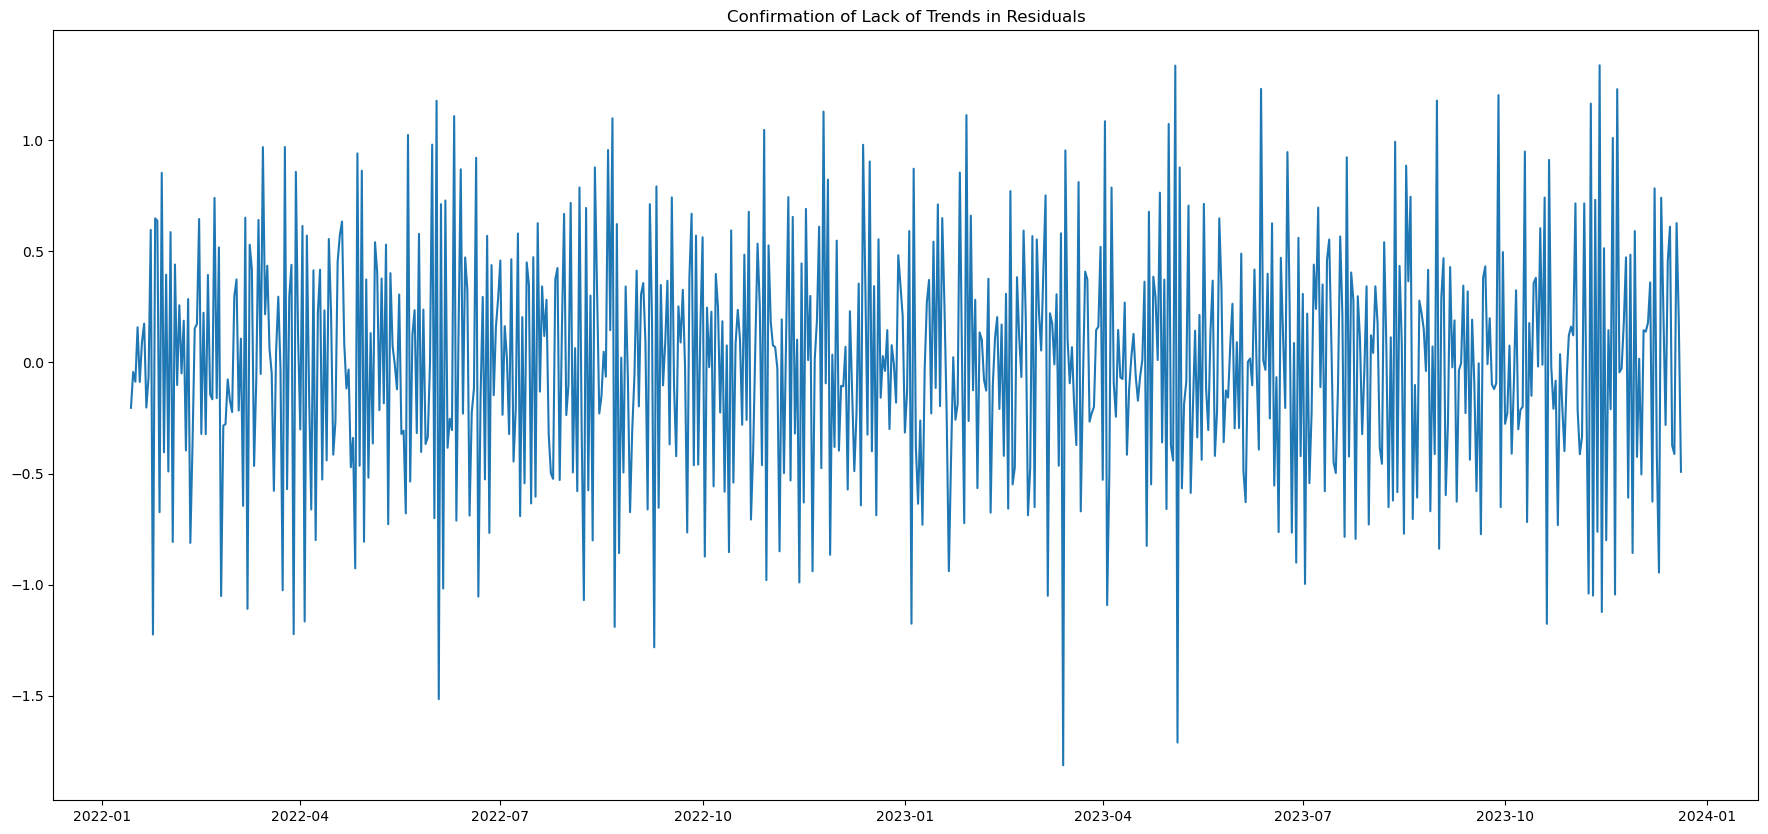

In [22]:
#plot the residuals using the decomposed data that was created above
plt.figure(figsize=(22,10))
plt.title("Confirmation of Lack of Trends in Residuals")
plt.plot(sd.resid);

Based on the graph above, the residuals of the decomposed time series do not appear to have any trend.

### D2: ARIMA Model <a class="anchor" id="D2"></a>

Using the autocorrelation plots from above we can determine how best to order our model for optimal functionality. Looking at the plots it would seem that the best order for this time series would be (2, 0, 0).

In [23]:
#install pmdarima

!pip install pmdarima

In [24]:
#Create the ARIMA model 
#Import ARIMA from statsmodels library in order to create the model
from pmdarima.arima import auto_arima

model = auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=493,n_fits=50)
print(model.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1909.794, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1298.490, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1480.242, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1211.491, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1190.492, Time=0.61 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1179.597, Time=0.98 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1159.743, Time=2.22 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=11.10 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=7.19 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1603.170, Time=1.10 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=1027.108, Time=2.11 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=1038.472, Time=1.07 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=14.66 sec
 ARIMA(2,1,0)(4,1,1)[12]             

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  584
Model:             SARIMAX(5, 1, 0)x(5, 1, 0, 12)   Log Likelihood                -459.367
Date:                            Wed, 12 Jun 2024   AIC                            940.734
Time:                                    17:15:41   BIC                            988.556
Sample:                                01-02-2022   HQIC                           959.391
                                     - 08-08-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3077      0.044    -29.748      0.000      -1.394      -1.222
ar.L2         -1.0293      0.069    -14.942      0.000      -1.164      -0.894
ar.L3         -0.7125      0.075     -9.438      0.000      -0.861      -0.565
ar.L4         -0.4428      0.065     -6.848      0.000      -0.570      -0.316
ar.L5         -0.1774      0.042     -4.274      0.000      -0.259      -0.096
ar.S.L12      -0.9028      0.046    -19.506      0.000      -0.994      -0.812
ar.S.L24      -0.7286      0.060    -12.105      0.000      -0.847      -0.611
ar.S.L36      -0.4794      0.069     -6.955      0.000      -0.614      -0.344
ar.S.L48      -0.3018      0.058     -5.209      0.000      -0.415      -0.188
ar.S.L60      -0.1830      0.043     -4.223      0.000      -0.268      -0.098
sigma2         0.2849      0.017     16.320      0.000       0.251       0.319
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.49   Prob(JB):                         0.56
Heteroskedasticity (H):               1.00   Skew:                            -0.10
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Revenue'], order=(5,1,0), seasonal_order=(5, 1, 0, 12), freq='D')
results = model.fit()
results.summary()

C:\Users\sered\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          Revenue   No. Observations:                  731
Model:             ARIMA(5, 1, 0)x(5, 1, 0, 12)   Log Likelihood                -593.751
Date:                          Wed, 12 Jun 2024   AIC                           1209.502
Time:                                  17:15:45   BIC                           1259.843
Sample:                              01-01-2022   HQIC                          1228.939
                                   - 01-01-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3224      0.039    -34.278      0.000      -1.398      -1.247
ar.L2         -1.0525      0.061    -17.138      0.000      -1.173      -0.932
ar.L3         -0.7342      0.068    -10.738      0.000      -0.868      -0.600
ar.L4         -0.4346      0.060     -7.228      0.000      -0.552      -0.317
ar.L5         -0.1724      0.037     -4.607      0.000      -0.246      -0.099
ar.S.L12      -0.8666      0.040    -21.402      0.000      -0.946      -0.787
ar.S.L24      -0.6904      0.052    -13.332      0.000      -0.792      -0.589
ar.S.L36      -0.4416      0.060     -7.402      0.000      -0.559      -0.325
ar.S.L48      -0.2965      0.051     -5.844      0.000      -0.396      -0.197
ar.S.L60      -0.1769      0.039     -4.585      0.000      -0.253      -0.101
sigma2         0.2944      0.016     17.880      0.000       0.262       0.327
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.40   Prob(JB):                         0.65
Heteroskedasticity (H):               1.05   Skew:                            -0.02
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### D3: ARIMA Model Forecast <a class="anchor" id="D3"></a>

In [27]:
#Create a forecast based on the ARIMA model created above
forecast = pd.DataFrame(results.predict(start=585, end=731, dynamic=True), index=test.index)
#forecast.columns = ['forecast_revenue']
forecast

,predicted_mean
Day,
2023-08-09,-0.127680
2023-08-10,-0.052658
2023-08-11,0.582548
2023-08-12,0.117500
2023-08-13,0.070422
...,...
2023-12-28,0.075087
2023-12-29,0.280284
2023-12-30,0.461741


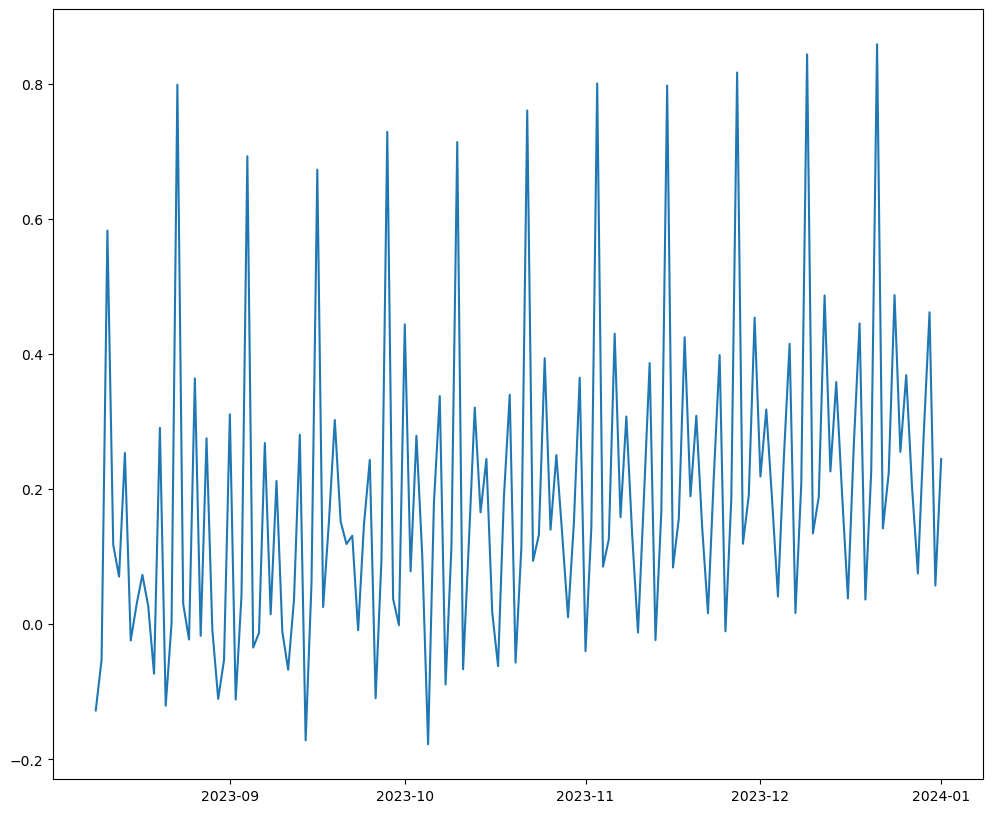

In [28]:
#plot the forecast
plt.figure(figsize=(12,10))
plt.plot(forecast);

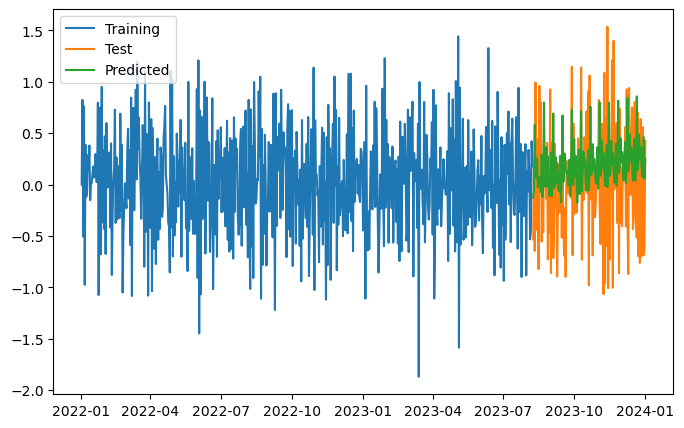

In [29]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(forecast,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

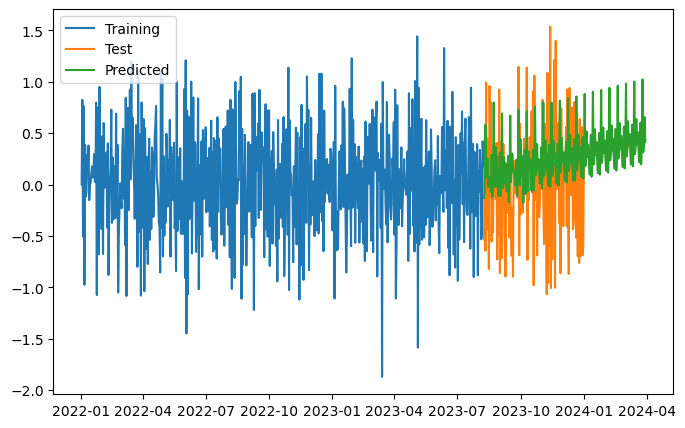

In [30]:
#perform a forecast to predict future dates

from pandas.tseries.offsets import DateOffset

future_dates = [df.index[-1] + DateOffset(days=x) for x in range (0,90)]
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=df.columns)

future_dates_df.tail()

future_df = pd.concat([df,future_dates_df])

new_forecast = pd.DataFrame(results.predict(start=585, end=821, dynamic=True), index=future_df.index)

#Create visualization with future forecast data
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(new_forecast,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

From the above graph we can see the training data in blue, test data in orange, and the predicted forecast data in green. The forecast data was calculated another 90 days after the time series data ended which gives us an idea of where the revenue is headed for the company. Based off of the graph I can tell that the predicted data is not fitting well with the test data which makes me think that the model is not as optimized and accurate as one would like. 

The model above runs from January 1, 2022 - April 1, 2024 after including the future predicted forecast. 

### D4: Output and Calculations  <a class="anchor" id="D4"></a>

All output and calculations can be found above and some below in the Jupyter Labs notebook.

### D5: Code Used for Model <a class="anchor" id="D5"></a>

All code used for the model can be found above and some below in the Jupyter Labs notebook.

## Part 5 - Data Summary and Implications <a class="anchor" id="Part5"></a>

### E1: Results <a class="anchor" id="E1"></a>

### Selection of the ARIMA Model <a class="anchor" id="Selection"></a>

The ARIMA model is a great forecasting tool to help individuals and companies to predict how something is going to act based on current data and past performance. Using ARIMA gives a company the capability of seeing how an asset might act in the future which leads them to make smart business decisions. ARIMA was a good model to use for this dataset since we are working with revenue. Using ARIMA we are able to predict how the revenue of the compnay might act in the future based on past revenue trends.

The ARIMA model used was optimized by using the auto_arima method to choose the best order for the model. When using this method it steps through each possibility taking into account the seasonality and trend of the time series and chooses the best model order. The three month prediction of revenue provided by the model gives the company an idea of future possibilites and enables them to act accordingly.

### Prediction and Confidence Interval of the Forecast <a class="anchor" id="Prediction"></a>

In [31]:
confidence_int_forecast = results.get_prediction(start = 585, end = 821, dynamic = True)
confidence_int = confidence_int_forecast.conf_int()
confidence_int

,lower Revenue,upper Revenue
2023-08-09,-1.191198,0.935838
2023-08-10,-1.170066,1.064750
2023-08-11,-0.603461,1.768557
2023-08-12,-1.074352,1.309352
2023-08-13,-1.153602,1.294447
...,...,...
2024-03-28,-12.861600,13.623931
2024-03-29,-12.659535,13.975522
2024-03-30,-12.979348,13.804780
2024-03-31,-12.931024,13.995826


For this project the prediction interval for the time series is 236 days. That number comprises 146 days where we have test data to determine if the actual data is aligning with the predicted data and another 90 days to see where the revenue for the compnay is going based on the time sereies data. The prediction interval goes 90 days after the end of the test data. Looking at the prediction data and comparing it to the test data will help us determine if the model is functioning optimally or if more needs to be done to improve the model and its predictions.

Above we have determined the confidence intervals for the model which help to determine how good our estimations are for the model.

### Justification of the Forecast Length <a class="anchor" id="Length"></a>

For the project I chose to have my model forecast 90 days worth of prediction data. That 90 days gives the company an idea of revenue for an entire quarter of the year. This knowledge will help the company to make smart business decisions so that they can be as successful and profitable in the first quarter of 2024 as possible.

### Model Evaluation and Error Metric  <a class="anchor" id="Evaluation"></a>

In [32]:
#Use R2 test score to compare the forecast data with the test data - model evaluation
from sklearn.metrics import r2_score

r2_score(test['Revenue'], forecast['predicted_mean'])

-0.2133345865276819

In [33]:
#Error Metric - Mean Absolute Error
y = test['Revenue']
y_hat = forecast['predicted_mean']

def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

mae = np.mean(np.abs(y-y_hat))

mae

0.5049650744719663

In [34]:
#Error Metric - Root Mean Squared Error
rmse = np.sqrt(np.mean(np.square(y - y_hat)))
rmse

0.6283788797484093

As you can see from the R2 score above, the model fit could definitely be improved. The best possible score for R2 is 1 and the worst score is -2. The ARIMA model has a score of -0.213 which means that the model isn't fitting the test data well. From the MAE and RMSE scores that were used to determine error in the model we can see that our model needs some more optimization. The goal with both RMSE and MAE is to be as close to 0 as possible. Our MAE score is right above 50% which means that it is inaccurate more often than it is not. The RMSE score is at .628 which also implies that the model is making significant mistakes and fewwer accurate predictions.

### E2: Annotated Visualization <a class="anchor" id="E2"></a>

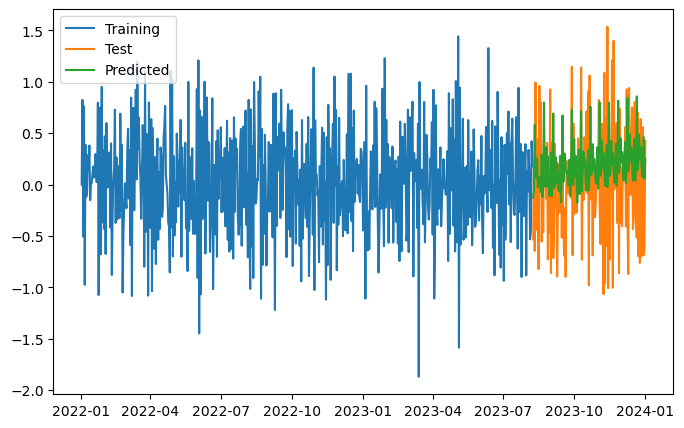

In [36]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(forecast,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

The above visualization is a depiction of the training data in blue, test data in orange, and the predicted revenue data in green. At a glance you can see that the prediction data is not aligning well with the test data which indicates that the model is not a good fit and is giving poor predictions. This was confirmed by evaluating our model. The error metrics that were run confirmed that the model is not a good fit for the data and is not providing accurate predictions.

### E3: Recommended Course of Action <a class="anchor" id="E3"></a>

After building the time series model and evaluating its performance, my recommendation would be to work on optimizing the model. With the error scores being so high, I don't have a lot of confidence in the forecast data that the model would produce. The dataset that was used to build this model was very small. Another course of action that I would recommend is to try to obtain more data to help train the time series model. If a model isn't trained well then it is not going to provide accurate predictions. Two things that I recommend to move forward with:
 - Try to obtain more data to train the model with. 731 data points is not enough to train an accurate model.
  - Continue to find ways to optimize the model to help the fit of the model as well as minimize the number of errors.

## Part 6 - Reporting <a class="anchor" id="Part6"></a>

### Create a Report Using an Interactive Development Environment

This report was created using Jupyter Notebook. I will attach an .ipynb file as well as a pdf file of the notebook.

### Sources Used for Third-Party Code


G, V. K. (2024, May 05). Statistical Tests to Check Stationarity in Time Series. Retrieved from Analytics Vidhya: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/



### Sources Used for In-Text Citations or Quoted, Paraphrased, and Summarized Content

Frost, J. (n.d.). Autocorrelation and Partial Autocorrelation in Time Series Data. Retrieved from Statistics by Jim: https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/#:~:text=In%20contrast%2C%20the%20partial%20autocorrelation,Moving%20Average%20(ARIMA)%20models.

### Professional Communication

Please see this document to determine professional communication.